# Generate a plot of multiple SEDs

In [1]:
%load_ext autoreload
%autoreload 2

import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import syncfit

VLA_nus = np.linspace(0.11,50) #GHz
ALMA_nus = np.linspace(35, 950) # GHz

In [2]:
def row_to_val(row, key='Flux Density'):
    if '<' in row[key]:
        return float(row[key].replace(' ','')[1:])
    return float(row[key].split('+')[0])

def row_to_err(row, key='Flux Density'):
    if '<' in row[key]:
        return 0
    return float(row[key].split('-')[-1])

def is_upperlimit(row, key='Flux Density'):
    if '<' in row[key]:
        return True
    return False

def get_facility(row):
    if '-' in row['Array Configuration']:
        return 'ALMA'
    return 'VLA'

def label(row, obj_name):
    # if row.t < 100: # if the time is less than 100 days
    #     # this is an "early time" observation
    #     return obj_name+r' ($\Delta t < 100$ days)'
    return obj_name#+r' ($\Delta t > 100$ days)'

In [3]:
# First Sw J1644+57
SwJ1644_files = glob.glob('SwJ1644+57*')

allswfiles = []
cite_map = {'Berger2012':'Berger et al. (2012)',
            'Zauderer2013': 'Zauderer et al. (2013)',
            'Eftekhari2018': 'Eftekhari et al. (2018)'}
for f in SwJ1644_files:
    df = pd.read_csv(f, sep='\t') 
    for c in cite_map.keys():
        if c in f:
            df['Citation'] = [cite_map[c]]*len(df)
            continue

    allswfiles.append(df)
    
SwJ1644_data = pd.concat(allswfiles)
SwJ1644_data.Facility = SwJ1644_data.Facility.fillna('VLA') # all of these observations were with the VLA

# clean the data
del SwJ1644_data['Unnamed: 4']
del SwJ1644_data['Unnamed: 3']
SwJ1644_data = SwJ1644_data.drop(0)

SwJ1644_data['FluxDensity'] = SwJ1644_data.apply(row_to_val, axis=1)
SwJ1644_data['FluxDensityErr'] = SwJ1644_data.apply(row_to_err, axis=1)

del SwJ1644_data['Flux Density']

SwJ1644_data.Frequency = SwJ1644_data.Frequency.astype(float)
SwJ1644_data.t = SwJ1644_data.t.astype(float)


ts = SwJ1644_data.t.unique()
m, M = int(ts.min()), int(ts.max())

vals = np.logspace(np.log10(m),np.log10(M), 11, dtype=int)
SwJ1644_data['TimeGroup'] = np.zeros(len(SwJ1644_data))
SwJ1644_data['Object'] = SwJ1644_data.apply(label, obj_name='Sw J1644+57', axis=1)
for idx, row in SwJ1644_data.iterrows():
    
    for val_min, val_max in zip(vals[:-1], vals[1:]):
        if row.t >= val_min and row.t <= val_max:
            SwJ1644_data.TimeGroup[idx] = f'{val_min}-{val_max} days'
            break
            
SwJ1644_data['t'] = SwJ1644_data.t.astype(float)
SwJ1644_data

/tmp/ipykernel_2113369/2284446150.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SwJ1644_data.TimeGroup[idx] = f'{val_min}-{val_max} days'


,t,Facility,Frequency,Citation,FluxDensity,FluxDensityErr,TimeGroup,Object
1,244.23,JVLA,1.8,Zauderer et al. (2013),2.29,0.08,5-10 days,Sw J1644+57
2,271.95,JVLA,1.8,Zauderer et al. (2013),2.02,0.23,75-143 days,Sw J1644+57
3,383.92,JVLA,1.8,Zauderer et al. (2013),4.37,0.10,143-273 days,Sw J1644+57
4,452.66,JVLA,1.8,Zauderer et al. (2013),3.77,0.09,143-273 days,Sw J1644+57
5,581.31,JVLA,1.8,Zauderer et al. (2013),2.88,0.08,3-5 days,Sw J1644+57
...,...,...,...,...,...,...,...,...
249,18.25,SMA,230.0,Berger et al. (2012),9.90,1.40,10-20 days,Sw J1644+57
250,20.24,SMA,230.0,Berger et al. (2012),8.20,1.40,20-39 days,Sw J1644+57
251,21.25,SMA,230.0,Berger et al. (2012),8.30,2.20,20-39 days,Sw J1644+57
252,125.05,SMA,230.0,Berger et al. (2012),6.10,0.65,75-143 days,Sw J1644+57


In [4]:
# Now AT2019dsg
dsg = pd.read_csv('AT2019dsg_Cendes2021.txt', sep=',')

dsg['FluxDensity'] = dsg.apply(row_to_val, axis=1)
dsg['FluxDensityErr'] = dsg.apply(row_to_err, axis=1)
dsg['Upperlimit'] = dsg.apply(is_upperlimit, axis=1)
dsg['Facility'] = dsg.apply(get_facility, axis=1)
dsg['Object'] = dsg.apply(label, obj_name='AT2019dsg', axis=1)

dsg['t'] = dsg.t.astype(float) 
dsg['Citation'] = ['Cendes et al. (2021)']*len(dsg)

dsg

,Date,t,Array Configuration,Frequency,Flux Density,FluxDensity,FluxDensityErr,Upperlimit,Facility,Object,Citation
0,2019 May 24,55.0,B,5.0,0.09 +or- 0.01,0.09,0.01,False,VLA,AT2019dsg,Cendes et al. (2021)
1,2019 May 24,55.0,B,7.0,0.19 +or- 0.01,0.19,0.01,False,VLA,AT2019dsg,Cendes et al. (2021)
2,2019 May 24,55.0,B,13.0,0.48 +or- 0.02,0.48,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
3,2019 May 24,55.0,B,15.0,0.54 +or- 0.02,0.54,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
4,2019 May 24,55.0,B,17.0,0.58 +or- 0.02,0.58,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
...,...,...,...,...,...,...,...,...,...,...,...
57,2020 Jan 24,300.0,D,17.0,0.23 +or- 0.03,0.23,0.03,False,VLA,AT2019dsg,Cendes et al. (2021)
58,2020 Oct 11,561.0,B,1.5,0.35 +or- 0.05,0.35,0.05,False,VLA,AT2019dsg,Cendes et al. (2021)
59,2020 Oct 11,561.0,B,2.6,0.26 +or- 0.02,0.26,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
60,2020 Oct 11,561.0,B,3.4,0.17 +or- 0.01,0.17,0.01,False,VLA,AT2019dsg,Cendes et al. (2021)


In [5]:
# AT2022cmc

cmc = pd.read_csv('AT2022cmc_Andreoni2022.txt', sep='&')

cmc = cmc.drop(0)
print(cmc[' nu '])
cmc['Frequency'] = cmc[' nu '].astype(float)#
cmc['t'] = cmc[' Delta t '].astype(float)
cmc['FluxDensity'] = cmc.apply(row_to_val, key=' F_nu ', axis=1).astype(float)*1e-3 # convert from uJy to mJy
cmc['FluxDensityErr'] = cmc['  RMS'].astype(float)*1e-3
cmc['Object'] = cmc.apply(label, obj_name='AT2022cmc', axis=1)
cmc['Citation'] = ['Andreoni et al. (2022)']*len(cmc)

cmc

1        8.5
2        9.5
3       10.5
4       11.5
5        8.5
       ...  
121     11.5
122     12.8
123     14.3
124     15.9
125     17.4
Name:  nu , Length: 125, dtype: object


,#Facility,UT date,Delta t,nu,F_nu,RMS,Frequency,t,FluxDensity,FluxDensityErr,Object,Citation
1,VLA,2022-02-15 12:30,4.07,8.5,33,7,8.5,4.07,0.033,0.007,AT2022cmc,Andreoni et al. (2022)
2,VLA,2022-02-15 12:30,4.07,9.5,46,7,9.5,4.07,0.046,0.007,AT2022cmc,Andreoni et al. (2022)
3,VLA,2022-02-15 12:30,4.07,10.5,51,8,10.5,4.07,0.051,0.008,AT2022cmc,Andreoni et al. (2022)
4,VLA,2022-02-15 12:30,4.07,11.5,68,9,11.5,4.07,0.068,0.009,AT2022cmc,Andreoni et al. (2022)
5,VLA,2022-02-16 12:19,5.07,8.5,43,8,8.5,5.07,0.043,0.008,AT2022cmc,Andreoni et al. (2022)
...,...,...,...,...,...,...,...,...,...,...,...,...
121,VLA,2022-03-31 04:13,47.73,11.5,438,14,11.5,47.73,0.438,0.014,AT2022cmc,Andreoni et al. (2022)
122,VLA,2022-03-31 04:23,47.74,12.8,583,12,12.8,47.74,0.583,0.012,AT2022cmc,Andreoni et al. (2022)
123,VLA,2022-03-31 04:23,47.74,14.3,724,12,14.3,47.74,0.724,0.012,AT2022cmc,Andreoni et al. (2022)
124,VLA,2022-03-31 04:23,47.74,15.9,801,14,15.9,47.74,0.801,0.014,AT2022cmc,Andreoni et al. (2022)


# Merge all the data and plot it

In [6]:
def sefd(nu, min_rms=1e-6, npol=1, dt=3600): 
    # from https://leo.phys.unm.edu/~lwa/obsstatus/obsstatus006.html
    return min_rms*np.sqrt(2*npol*nu*dt)*1e3 # calculate and convert from Jy -> mJy

In [7]:
data = pd.concat([SwJ1644_data, dsg, cmc])
data

,t,Facility,Frequency,Citation,FluxDensity,FluxDensityErr,TimeGroup,Object,Date,Array Configuration,Flux Density,Upperlimit,#Facility,UT date,Delta t,nu,F_nu,RMS
1,244.23,JVLA,1.8,Zauderer et al. (2013),2.290,0.080,5-10 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,271.95,JVLA,1.8,Zauderer et al. (2013),2.020,0.230,75-143 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,383.92,JVLA,1.8,Zauderer et al. (2013),4.370,0.100,143-273 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,452.66,JVLA,1.8,Zauderer et al. (2013),3.770,0.090,143-273 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,581.31,JVLA,1.8,Zauderer et al. (2013),2.880,0.080,3-5 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,47.73,NaN,11.5,Andreoni et al. (2022),0.438,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:13,47.73,11.5,438,14
122,47.74,NaN,12.8,Andreoni et al. (2022),0.583,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,12.8,583,12
123,47.74,NaN,14.3,Andreoni et al. (2022),0.724,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,14.3,724,12
124,47.74,NaN,15.9,Andreoni et al. (2022),0.801,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,15.9,801,14


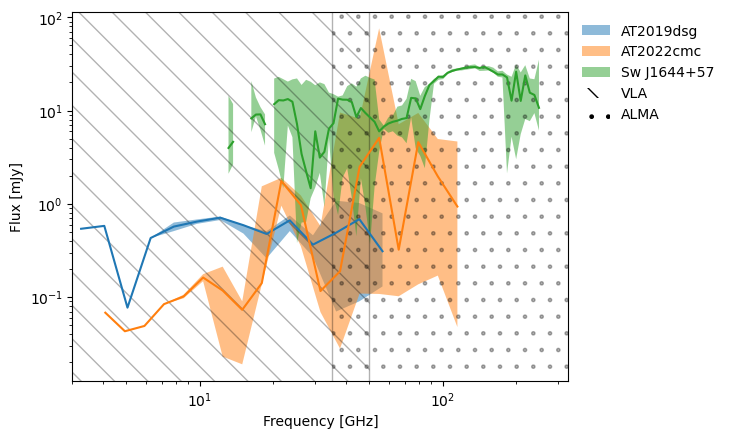

In [8]:
fig, ax = plt.subplots()
bin_factor = 3

for lab, grp in data.groupby('Object'):
    nbins = len(grp)//bin_factor
    bins = np.logspace(np.log10(grp.Frequency.min()), np.log10(grp.Frequency.max()), nbins)
    grp['range'] = pd.cut(grp.index, 
                          bins, 
                          retbins=False)
    avgs = grp.groupby('range').FluxDensity.agg(['min', 'max', 'median'])
    bincenter = list(avgs.index.map(lambda interval: (interval.left+interval.right)/2))
    
    # plot a 2 std region
    ax.fill_between(bincenter, avgs['min'], avgs['max'], alpha=0.5, label=lab)
    ax.plot(bincenter, avgs['median'])

ax.set_xscale('log')
ax.set_yscale('log')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
    
ax.fill_between(VLA_nus, [1e-50]*len(VLA_nus), [1000]*len(VLA_nus), label='VLA', alpha=0.3, facecolor="none", hatch="\\")
ax.fill_between(ALMA_nus, [1e-50]*len(ALMA_nus), [1000]*len(ALMA_nus), label='ALMA', alpha=0.3, facecolor="none", hatch=".",)

ax.set_ylim(*ylim)
ax.set_xlim(3, xlim[1])
ax.set_ylabel('Flux [mJy]')
ax.set_xlabel('Frequency [GHz]')
ax.legend(bbox_to_anchor=(1.32, 1), frameon=False,)

fig.savefig('SEFD-plot.png', transparent=False, bbox_inches='tight')

In [9]:
data

,t,Facility,Frequency,Citation,FluxDensity,FluxDensityErr,TimeGroup,Object,Date,Array Configuration,Flux Density,Upperlimit,#Facility,UT date,Delta t,nu,F_nu,RMS
1,244.23,JVLA,1.8,Zauderer et al. (2013),2.290,0.080,5-10 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,271.95,JVLA,1.8,Zauderer et al. (2013),2.020,0.230,75-143 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,383.92,JVLA,1.8,Zauderer et al. (2013),4.370,0.100,143-273 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,452.66,JVLA,1.8,Zauderer et al. (2013),3.770,0.090,143-273 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,581.31,JVLA,1.8,Zauderer et al. (2013),2.880,0.080,3-5 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,47.73,NaN,11.5,Andreoni et al. (2022),0.438,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:13,47.73,11.5,438,14
122,47.74,NaN,12.8,Andreoni et al. (2022),0.583,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,12.8,583,12
123,47.74,NaN,14.3,Andreoni et al. (2022),0.724,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,14.3,724,12
124,47.74,NaN,15.9,Andreoni et al. (2022),0.801,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,15.9,801,14


# Model the SEDs

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.01it/s]


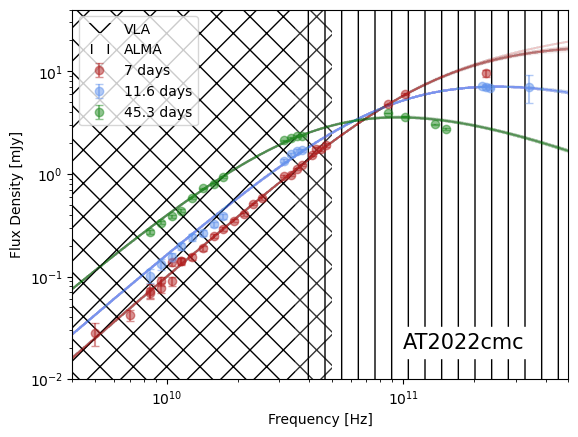

In [10]:
import syncfit

centervals = [7, 11.6, 45.3]
tols = [1, 0.5, 5]
theta_inits = [3, 1, 10, 11]
n = 100
burnin = n//2
model = syncfit.models.B1B2
nkeep = 100
cols = ['firebrick', 'cornflowerblue', 'forestgreen']

fig, ax = plt.subplots()

for val, tol, c in zip(centervals, tols, cols):

    ds = cmc[np.isclose(cmc.t, val, atol=tol)]
    ds = ds[ds.Frequency > 3]
    
    lines = ax.errorbar(1e9*ds.Frequency, ds.FluxDensity, fmt='o', yerr=ds.FluxDensityErr, 
                label=f'{val} days', alpha=0.5, capsize=3, color=c)
    
    
    # with mm data
    sampler = syncfit.do_emcee(theta_inits, ds.Frequency.astype(float), ds.FluxDensity*1e3, 
                                ds.FluxDensityErr*1e3, plot=False, niter=n, model=model)
    out, log_prob = syncfit.analysis.extract_output(sampler)
    nus = np.arange(1e8,5e12,1e7)  
    sed = model.SED
    best = out[np.argsort(log_prob)[-nkeep:]]
    for o in best:
        res = sed(nus, *o)
        ax.plot(nus, res, alpha=0.01, linestyle='-', color=lines[-1][0].get_color())
    
ax.set_ylabel(r'Flux Density [mJy]')
ax.set_xlabel('Frequency [Hz]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.text(1e11, 2e-2, 'AT2022cmc', fontsize=15, backgroundcolor='w')
ax.set_ylim(1e-2, 4e1)
ax.set_xlim(4e9, 5e11)

ax.fill_between(VLA_nus*1e9, [1e-50]*len(VLA_nus), [1000]*len(VLA_nus), label='VLA', alpha=0.2, facecolor='w', hatch="x")
ax.fill_between(ALMA_nus*1e9, [1e-50]*len(ALMA_nus), [1000]*len(ALMA_nus), label='ALMA', alpha=0.2, facecolor="w", hatch="|",)

ax.legend()

fig.savefig('2022cmc-sed-plot.png', transparent=False, bbox_inches='tight')

# AT2019dsg

In [33]:
class CustomB5B3(syncfit.models.B5B3):
    
    # We just need to update the smoothing parameters here!
    
    def SED(nu, p, log_F_nu, log_nu_a, log_nu_c):
        b1 = 2
        b2 = 5/2
        b3 = (1-p)/2
        b4 = -p/2

        s1 = 3.63*p-1.6
        s2 = 1.25-0.18*p
        s3 = 10

        F_nu = 10**log_F_nu
        nu_m = 0.1*1e9
        nu_a = 10**log_nu_a
        nu_c = 10**log_nu_c


        term1 = ( (nu/nu_m)**(b1) * np.exp(-s1*(nu/nu_m)**(2/3)) + (nu/nu_m)**(b2))
        term2 = ( 1 + (nu/nu_a)**(s2*(b2-b3)) )**(-1/s2)
        term3 = ( 1 + (nu/nu_c)**(s3*(b3-b4)) )**(-1/s3)
        
        return F_nu * term1 * term2 * term3
    
    def lnprior(theta, p=None, **kwargs):
        ''' Priors: '''
        if p is None:
            p, log_F_nu, log_nu_a, log_nu_c = theta
        else:
            log_F_nu, log_nu_a, log_nu_c = theta

        if 2 < p < 4 and -8 < log_F_nu < 0 and 9 < log_nu_a < 11 and 10.35 < log_nu_c < 11:
            return 0.0

        else:
            return -np.inf
    
class CustomB5(syncfit.models.B5):
    
    def SED(nu, p, log_F_nu, log_nu_a):
        b1 = 2
        b2 = 5/2
        b3 = (1-p)/2
        b4 = -p/2

        s1 = 3.63*p-1.6
        s2 = 1.25-0.18*p
        s3 = 10

        F_nu = 10**log_F_nu
        nu_m = 0.1*1e9
        nu_a = 10**log_nu_a

        term1 = ( (nu/nu_m)**(b1) * np.exp(-s1*(nu/nu_m)**(2/3)) + (nu/nu_m)**(b2))
        term2 = ( 1 + (nu/nu_a)**(s2*(b2-b3)) )**(-1/s2)
        
        return F_nu * term1 * term2
    
    def lnprior(theta, p=None, **kwargs):
        ''' Priors: '''
        if p is None:
            p, log_F_nu, log_nu_a = theta
        else:
            log_F_nu, log_nu_a = theta

        if 2 < p < 4 and -8 < log_F_nu < 0 and 9 < log_nu_a < 11:
            return 0.0

        else:
            return -np.inf


In [34]:
ds = dsg[np.isclose(dsg.t, 83, atol=2)]
import syncfit

In [35]:
10**10.4 / 1e9

25.11886431509582

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 68.21it/s]


Best fit values for day:  None
\mathrm{p} = 3.61e+00_{-0.372}^{0.263}
\mathrm{log F_v} = -4.57e+00_{-0.032}^{0.036}
\mathrm{log nu_a} = 9.96e+00_{-0.017}^{0.023}
\mathrm{log nu_c} = 1.05e+01_{-0.093}^{0.424}


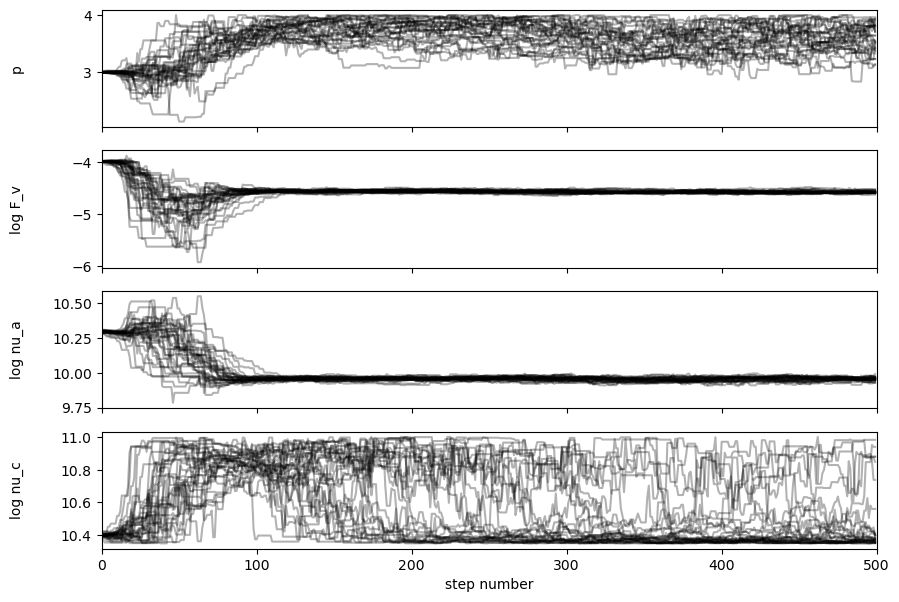

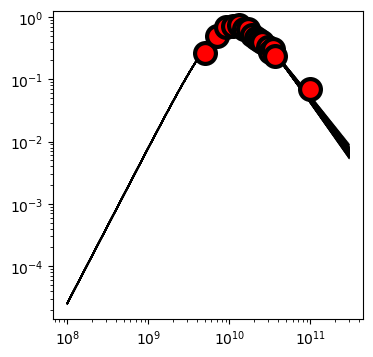

In [36]:
# try to fit the data
theta_inits = [3,-4,10.3,10.4]
n = 500
model = CustomB5B3 #syncfit.models.B5B3
# p = syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a', 'log nu_c'], discard=1000)[0][0]

F_uJy = ds.FluxDensity*1e3
F_err_uJy = ds.FluxDensityErr*1e3

sampler = syncfit.do_emcee(theta_inits, ds.Frequency, F_uJy, F_err_uJy, 
                                plot=True, niter=n, model=model, nwalkers=32)

out, log_prob = syncfit.analysis.extract_output(sampler)

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 63.67it/s]


Best fit values for day:  None
\mathrm{log F_v} = -4.56e+00_{-0.021}^{0.024}
\mathrm{log nu_a} = 9.95e+00_{-0.008}^{0.009}


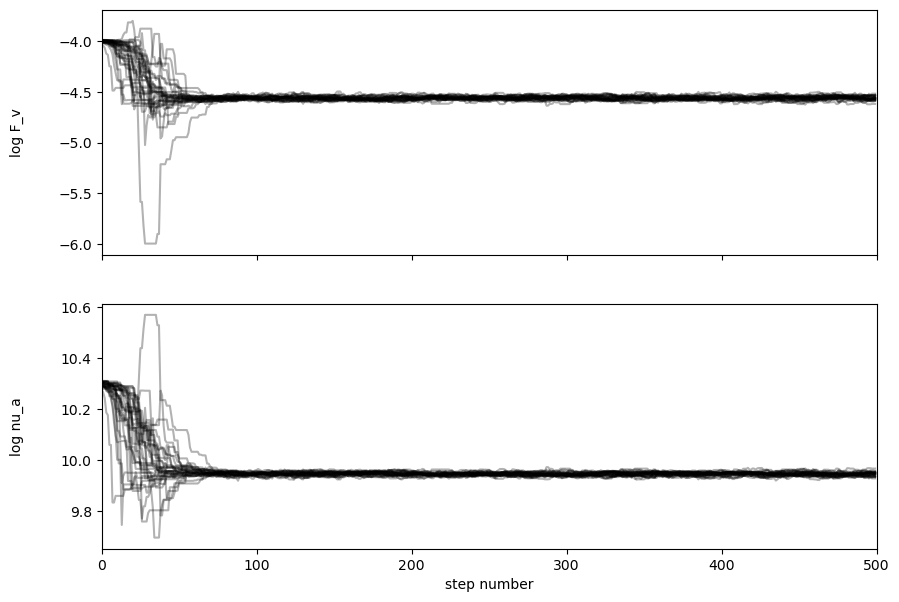

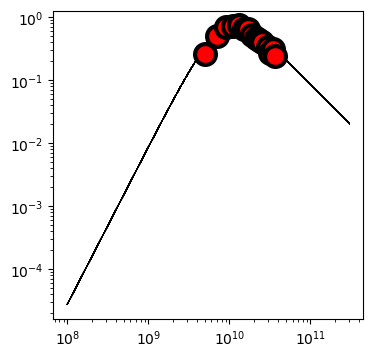

In [37]:
# without mm fit

# try to fit the data
theta_inits = [-4,10.3]
n = 500
model = CustomB5
p = syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a', 'log nu_c'], discard=n//2)[0][0]

F_uJy = ds.FluxDensity[ds.Frequency < 8e10/1e9]*1e3
F_err_uJy = ds.FluxDensityErr[ds.Frequency < 8e10/1e9]*1e3

sampler_nomm = syncfit.do_emcee(theta_inits, ds.Frequency[ds.Frequency < 8e10/1e9], F_uJy, F_err_uJy, 
                                plot=True, niter=n, model=model, nwalkers=32, fix_p=p)

out_nomm, log_prob_nomm = syncfit.analysis.extract_output(sampler_nomm)

(1000000000.0, 40000000000.0)

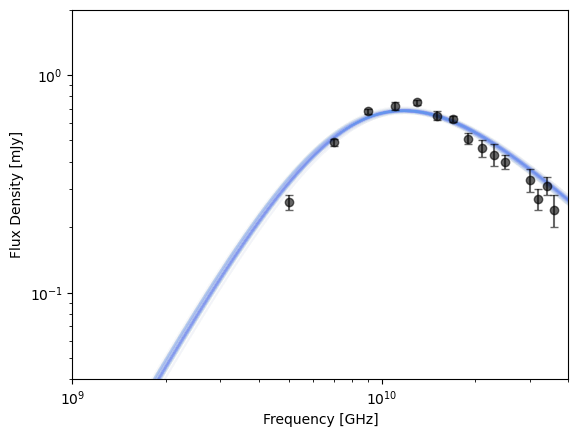

In [38]:
# plot up the data
fig, ax = plt.subplots()
nkeep = 200
nus = np.arange(1e8,3e11,1e7)
best = out_nomm[-nkeep:]#[np.argsort(log_prob_nomm)[-nkeep:]]
nus = np.arange(1e8,3e11,1e7)
for o in best:
    res = CustomB5.SED(nus, p, *o) #
    ax.plot(nus, res, alpha=0.01, linestyle='-', color='cornflowerblue')

F_mJy = ds.FluxDensity[ds.Frequency < 8e10/1e9]
F_err_mJy = ds.FluxDensityErr[ds.Frequency < 8e10/1e9]
ax.errorbar(ds.Frequency[ds.Frequency < 8e10/1e9]*1e9, F_mJy, yerr=F_err_mJy, fmt='o', alpha=0.6, color='k', capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Flux Density [mJy]')
ax.set_xlabel('Frequency [GHz]')

ax.set_ylim(4e-2, 2e0)
ax.set_xlim(1e9, 4e10)

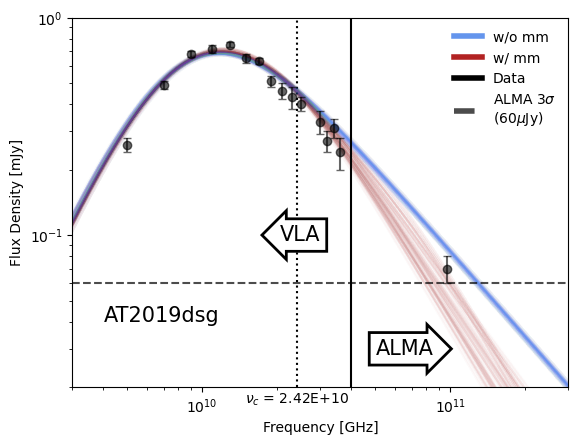

In [39]:
# plot up the data
fig, ax = plt.subplots()
nkeep = 200
nus = np.arange(1e8,3e11,1e7)
best = out[-nkeep:]#[np.argsort(log_prob)[-nkeep:]] #  
for o in best:
    res = CustomB5B3.SED(nus, *o)
    ax.plot(nus, res, alpha=0.01, linestyle='-', color='firebrick')

# # plot nu_c vertical line
nu_c = 10**syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a', 'log nu_c'], discard=n//2)[0][-1]
ax.axvline(nu_c, linestyle=':', color='k') # pulled from the printout above
ax.text(nu_c, 1.75e-2, r'$\nu_c$ = {:.2E}'.format(nu_c), ha='center', va='center')

best = out_nomm[-nkeep:]#[np.argsort(log_prob_nomm)[-nkeep:]]
nus = np.arange(1e8,3e11,1e7)
for o in best:
    res = CustomB5.SED(nus, p, *o) #
    ax.plot(nus, res, alpha=0.01, linestyle='-', color='cornflowerblue')
    
ax.set_ylim(2e-2, 1e0)
ax.set_xlim(3e9, 3e11)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

custom_lines = [Line2D([0], [0], color='cornflowerblue', lw=4),
                Line2D([0], [0], color='firebrick', lw=4),
                Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='k', alpha=0.7, linestyle='--', lw=4),
                Patch(facecolor='k', alpha=0.2, hatch='x'),
                Patch(facecolor='k', alpha=0.2, hatch='|')
               ]

labels = ['w/o mm', 'w/ mm', 'Data', 'ALMA 3$\sigma$ \n(60$\mu$Jy)']

ax.errorbar(ds.Frequency*1e9, ds.FluxDensity, yerr=ds.FluxDensityErr, fmt='o', alpha=0.6, color='k', capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Flux Density [mJy]')
ax.set_xlabel('Frequency [GHz]')

# ax.fill_between(VLA_nus*1e9, [1e-50]*len(VLA_nus), [1000]*len(VLA_nus), label='VLA', alpha=0.2, facecolor='w', hatch="x")
# ax.fill_between(ALMA_nus*1e9, [1e-50]*len(ALMA_nus), [1000]*len(ALMA_nus), label='ALMA', alpha=0.2, facecolor="w", hatch="|",)

ax.axvline(40e9, color='k', linestyle='-')
ax.text(30e9, 1e-1, "VLA",
        ha="right", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="larrow,pad=0.3", lw=2, fc='w', ec='k')
       )
ax.text(50e9, 3e-2, "ALMA",
        ha="left", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="rarrow,pad=0.3", lw=2, fc='w', ec='k')
       )

ax.axhline(60e-3, linestyle='--', color='k', alpha=0.7, label='ALMA 3$\sigma$ \n(60$\mu$Jy)')

ax.legend(custom_lines, labels, frameon=False, loc='upper right')

ax.text(4e9, 4e-2, 'AT2019dsg', fontsize=15, backgroundcolor='w')

fig.savefig('2019dsg-sed-plot.png', transparent=False, bbox_inches='tight')

# AT2019qiz

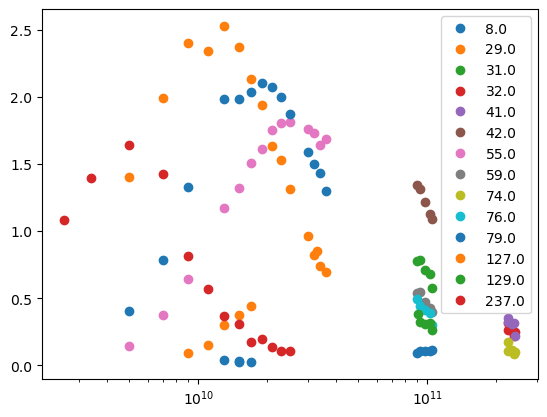

In [435]:
data = pd.DataFrame(np.loadtxt('AT2019qiz_sed.txt'), columns=['t', 'Frequency', 'FluxDensity', 'FluxDensityErr'])
data['FluxDensity'] = data.FluxDensity*1e-3
data['FluxDensityErr'] = data.FluxDensityErr*1e-3


fig, ax = plt.subplots()

# plot the data
for d,grp in data.groupby('t'):
    ax.errorbar(grp.Frequency*1e9, grp.FluxDensity, marker='o', linestyle='none', label=d)
    
ax.set_xscale('log')
ax.legend()

In [347]:
class CustomB5(syncfit.models.B5):
    
    def lnprior(theta, p=None, **kwargs):
        ''' Priors: '''
        if p is None:
            p, log_F_nu, log_nu_a = theta
        else:
            log_F_nu, log_nu_a = theta

        if 3< p < 5 and -4 < log_F_nu < 2 and 6 < log_nu_a < 11:
            return 0.0

        else:
            return -np.inf

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.76it/s]


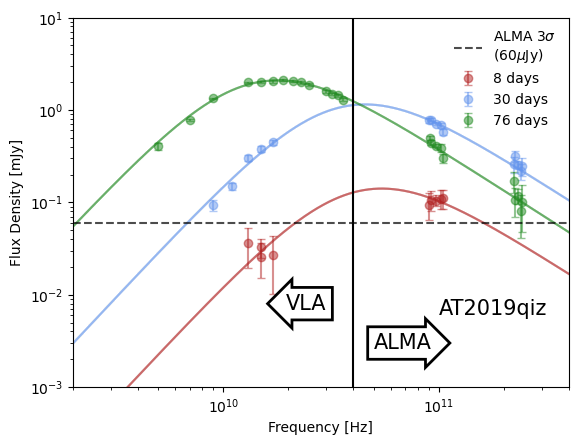

In [348]:
centervals = [8, 30, 76]
tols = [5, 5, 5]
theta_inits = [1, 10]
n = 1000
burnin = n//2
model = CustomB5 #syncfit.models.B5
nkeep = 10
cols = ['firebrick', 'cornflowerblue', 'forestgreen']
p = 4

fig, ax = plt.subplots()

for val, tol, c in zip(centervals, tols, cols):

    ds = data[np.isclose(data.t, val, atol=tol)]
              
    lines = ax.errorbar(1e9*ds.Frequency, ds.FluxDensity, fmt='o', yerr=ds.FluxDensityErr, 
                label=f'{val} days', alpha=0.5, capsize=3, color=c)
    
    
    # with mm data
    sampler = syncfit.do_emcee(theta_inits, ds.Frequency.astype(float), ds.FluxDensity*1e3, 
                                ds.FluxDensityErr*1e3, plot=False, niter=n, model=model, fix_p=p)
    
    out, log_prob = syncfit.analysis.extract_output(sampler)
    nus = np.arange(1e8,5e12,1e7)  
    sed = model.SED
    best = out[np.argsort(log_prob)[-nkeep:]]
    for o in best:
        res = sed(nus, p, *o)
        ax.plot(nus, res, alpha=0.1, linestyle='-', color=lines[-1][0].get_color())
    
ax.set_ylabel(r'Flux Density [mJy]')
ax.set_xlabel('Frequency [Hz]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.text(1e11, 6e-3, 'AT2019qiz', fontsize=15, backgroundcolor='w')
ax.set_ylim(1e-3, 1e1)
ax.set_xlim(2e9, 4e11)

ax.axvline(40e9, color='k', linestyle='-')
ax.text(30e9, 8e-3, "VLA",
        ha="right", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="larrow,pad=0.3", lw=2, fc='w', ec='k')
       )
ax.text(50e9, 3e-3, "ALMA",
        ha="left", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="rarrow,pad=0.3", lw=2, fc='w', ec='k')
       )

ax.axhline(60e-3, linestyle='--', color='k', alpha=0.7, label='ALMA 3$\sigma$ \n(60$\mu$Jy)')

ax.legend(loc='upper right', frameon=False)

fig.savefig('2019qiz-sed-plot.png', transparent=False, bbox_inches='tight')